In [6]:
%load_ext autoreload
%autoreload 2

import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

import os

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch
torch.set_default_tensor_type(torch.DoubleTensor)

import renyi
import utils
import sxp

import gal_data
import random

seed = 0 #0
np.random.seed(seed=seed)
random.seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
noise = 0.2
num_classes = 3
N_per_class = 50
R_per_class = 30
N_val = 50
N_test = 100

N_train = num_classes*N_per_class

foo = gal_data.create_synthetic_train(num_classes=num_classes, N_per_class=N_per_class, 
                                       input_noise=noise, R_per_class=R_per_class, seed=seed)
x_train, y_train, x_train_ordered, y_train_ordered = foo

x_val, y_val = gal_data.create_synthetic_test(num_classes=num_classes, N_per_class=N_val, input_noise=noise,seed=seed)
x_test, y_test = gal_data.create_synthetic_test(num_classes=num_classes, N_per_class=N_test, input_noise=noise,seed=seed)

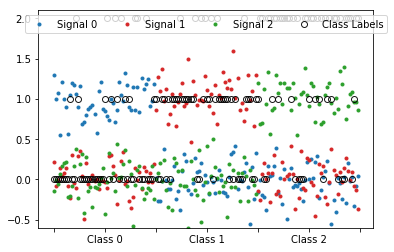

In [15]:
ax1 = plt.figure()
plt.plot(x_train_ordered[:,0],'.',color='tab:blue',label='Signal 0')
plt.plot(x_train_ordered[:,1],'.',color='tab:red',label='Signal 1')
plt.plot(x_train_ordered[:,2],'.',color='tab:green',label='Signal 2')
plt.plot(np.argmax(y_train_ordered,1),'o',alpha=0.9,color='k',markerfacecolor="None",label='Class Labels')
plt.ylim([-.6,2.1])
labels = [' ','Class 0',' ', 'Class 1',' ', 'Class 2',' ']
x = [0, 25,50,75,100,125,150]
plt.xticks(x, labels, rotation='horizontal')
plt.legend(loc='upper center', ncol=4)

plt.show()

In [22]:
M = 2.00001
util_mat = (M - np.array([[0,1,2],[0.8,0,0.7],[0.9,0.6,0]])) / M


print("         TRUTH\n" )
print('P  ', util_mat[0])
print('R  ', util_mat[1])
print('E  ', util_mat[2])


# Set up weight for weighted cross entropy
class_weight = {0 : 1.,
    1: 2,
    2: 2}

         TRUTH

P   [1.000000e+00 5.000025e-01 4.999975e-06]
R   [0.600002   1.         0.65000175]
E   [0.55000225 0.7000015  1.        ]


In [286]:
def simdiv(K, p, q, alpha=2, use_avg=False):
    tK = K.transpose(0, 1)
    pK = p @ tK
    qK = q @ tK

    if use_avg:
        r = (p + q) / 2
        rK = r @ tK
        rat1 = pK / utils.min_clamp(rK)
        rat2 = qK / utils.min_clamp(rK)
    else:   
        rat1 = pK / utils.min_clamp(qK)
        rat2 = qK / utils.min_clamp(pK)
    
    if np.allclose(alpha, 1.0):            
        dp1 = (p * torch.log(utils.min_clamp(rat1))).sum(dim=1)
        dp2 = 0+(q * torch.log(utils.min_clamp(rat2))).sum(dim=1)
        
        return dp1 + dp2
    else:    
        dp1 = (p * rat1**(alpha-1)).sum(dim=1)
        dp2 = 1*(q * rat2**(alpha-1)).sum(dim=1)

        return 1/(alpha - 1) * (torch.log(dp1) + torch.log(dp2))

In [426]:
class LR(torch.nn.Module):
    def __init__(self, in_feats, out_classes):
        super(LR, self).__init__()
        self.linear = torch.nn.Linear(in_feats, out_classes)
        
    def forward(self, x, apply_softmax=True):
        y_pred = self.linear(x)
        if apply_softmax:
            return torch.softmax(y_pred, dim=1)
        else:
            return y_pred

class MLP(torch.nn.Module):
    def __init__(self, in_feats, h_dim, out_classes):
        super(MLP, self).__init__()
        self.linear1 = torch.nn.Linear(in_feats, h_dim)
        self.linear2 = torch.nn.Linear(h_dim, out_classes)
        
    def forward(self, x, apply_softmax=True):
        y_pred = torch.relu(self.linear1(x))
        y_pred = self.linear2(y_pred)
        
        if apply_softmax:
            return torch.softmax(y_pred, dim=1)
        else:
            return y_pred

In [427]:
from sklearn.metrics import confusion_matrix

In [480]:
model = MLP(3, 100, 3)

# Util matrix is set up as (pred, true), tranpose so that internal
# transpose gets undone
K = torch.tensor(util_mat.transpose(0, 1)) #
p = torch.tensor(y_train)

optim = torch.optim.Adam(model.parameters(), lr=0.05, amsgrad=True)

q = model(torch.tensor(x_train), False)
confusion_matrix(np.argmax(y_train, axis=1), np.argmax(q.data.numpy(), axis=1))

BCELoss = torch.nn.BCEWithLogitsLoss()

loss_log = []

In [481]:
#simdiv(K, p, q, 1, True)


Down true, hor pred


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

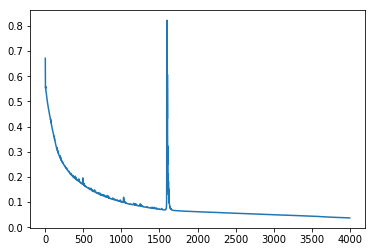

In [485]:

for op_step in range(1000):
    optim.zero_grad()
    q = model(torch.tensor(x_train), False)
    
    loss = BCELoss(q, p)
    
    #loss = simdiv(K, p, q, 3, True).mean()
    loss.backward()
    optim.step()
    
    loss_log.append(loss.item())

plt.plot(loss_log)    

q = model(torch.tensor(x_train))
print("\nDown true, hor pred")
cm = confusion_matrix(np.argmax(y_train, axis=1), np.argmax(q.data.numpy(), axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

cm